In [1]:
%matplotlib tk
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from callbacks import ModelTest
from keras.optimizers import SGD, RMSprop, Adagrad
from keras.models import Sequential, Input
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers import Concatenate
from keras.layers.recurrent import LSTM, GRU, SimpleRNN
from keras.regularizers import l2
import keras.metrics
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
import keras.backend as K
from theano.sandbox.rng_mrg import MRG_RandomStreams


Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce 820M (CNMeM is disabled, cuDNN not available)


In [3]:
from keras.datasets import mnist

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train.shape

(60000, 28, 28)

In [6]:
p_dropout = 0.5
weight_decay = 0.01
batch_size=400

In [7]:
# i=np.random.randint(0, len(y_train))
# plt.imshow(X_train[i], cmap=plt.cm.get_cmap('Greys'))
# plt.title(y_train[i])
# plt.show()

In [8]:
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)

In [9]:
#regression
# mean_y_train = np.mean(y_train)
# std_y_train = np.std(y_train)
# y_train = (y_train - mean_y_train) / std_y_train


In [10]:
#classification
mean_y_train = 0
std_y_train = 1
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [11]:
X_train = X_train / 255.0
X_test = X_test / 255.0

In [12]:
X_train.shape, X_train.min(), X_train.max()

((60000, 784), 0.0, 1.0)

In [13]:
from bayesian import BayesianDropoutModel, variation_ratio

In [14]:
theano_rng = MRG_RandomStreams(42)


In [26]:
# original loss from https://arxiv.org/pdf/1703.04977.pdf 
def bayesian_categorical_crossentropy_original(T, num_classes):
    def bayesian_categorical_crossentropy_internal_original(true, pred_var):
        # shape: (N,)
        std = K.sqrt(pred_var[:, num_classes])
        # shape: (N,)
        variance = pred_var[:, num_classes:]
        variance_depressor = K.exp(variance) - K.ones_like(variance)
        # shape: (N, C)
        pred = pred_var[:, 0:num_classes]
        # shape: (N,)
        undistorted_loss = K.categorical_crossentropy(pred, true, from_logits=True)
        # shape: (T,)
        iterable = K.variable(np.ones(T))
        dist = theano_rng.normal(avg=0, std=K.tile(std, (pred.shape[1], 1)).T, size=pred.shape)
        #distributions.Normal(loc=K.zeros_like(std), scale=std)
        monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy_original(true, pred, dist), iterable, name='monte_carlo_results')

        variance_loss = K.mean(monte_carlo_results, axis=0)# * undistorted_loss
        #return K.mean(theano_rng.normal(avg=0, std=1, size=(10,)))
        # return undistorted_loss
        return variance_loss# + undistorted_loss + variance_depressor
  
    return bayesian_categorical_crossentropy_internal_original

# for a single monte carlo simulation, 
#   calculate categorical_crossentropy of 
#   predicted logit values plus gaussian 
#   noise vs true values.
# true - true values. Shape: (N, C)
# pred - predicted logit values. Shape: (N, C)
# dist - normal distribution to sample from. Shape: (N, C)
# undistorted_loss - the crossentropy loss without variance distortion. Shape: (N,)
# num_classes - the number of classes. C
# returns - total differences for all classes (N,)
def gaussian_categorical_crossentropy_original(true, pred, dist):
    def map_fn(i):
        std_samples = dist#K.transpose(dist.sample(num_classes))
        distorted_logits = pred + std_samples
        #distorted_loss = K.categorical_crossentropy(distorted_logits, true, from_logits=True)
        #return distorted_loss
        #return K.categorical_crossentropy(true, pred, from_logits=True)
        #return K.log(K.sum(K.exp(pred), axis=1))
        distorted_loss = -K.sum(distorted_logits * true, axis=1) + K.log(K.sum(K.exp(distorted_logits), axis=1))
        distorted_loss2 = K.categorical_crossentropy(distorted_logits, true, from_logits=True)
        return distorted_loss - distorted_loss2
        
    return map_fn

In [27]:
# modified loss from https://medium.com/towards-data-science/building-a-bayesian-deep-learning-classifier-ece1845bc09
# standard categorical cross entropy
# N data points, C classes
# true - true values. Shape: (N, C)
# pred - predicted values. Shape: (N, C)
# returns - loss (N)
def categorical_cross_entropy(true, pred):
    return np.sum(true * np.log(pred), axis=1)

# Bayesian categorical cross entropy.
# N data points, C classes, T monte carlo simulations
# true - true values. Shape: (N, C)
# pred_var - predicted logit values and variance. Shape: (N, C + 1)
# returns - loss (N,)

def bayesian_categorical_crossentropy_elu(T, num_classes):
    def bayesian_categorical_crossentropy_internal_elu(true, pred_var):
        # shape: (N,)
        std = K.sqrt(pred_var[:, num_classes])
        # shape: (N,)
        variance = pred_var[:, num_classes]
        variance_depressor = K.exp(variance) - K.ones_like(variance)
        # shape: (N, C)
        pred = pred_var[:, 0:num_classes]
        # shape: (N,)
        undistorted_loss = K.categorical_crossentropy(pred, true, from_logits=True)
        # shape: (T,)
        iterable = K.variable(np.ones(T))
        dist = theano_rng.normal(avg=0, std=K.tile(std, (pred.shape[1], 1)).T, size=pred.shape)
        monte_carlo_results = K.map_fn(gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes), iterable, name='monte_carlo_results')

        variance_loss = K.mean(monte_carlo_results, axis=0) * undistorted_loss
        return variance_loss + undistorted_loss + variance_depressor
  
    return bayesian_categorical_crossentropy_internal_elu

# for a single monte carlo simulation, 
#   calculate categorical_crossentropy of 
#   predicted logit values plus gaussian 
#   noise vs true values.
# true - true values. Shape: (N, C)
# pred - predicted logit values. Shape: (N, C)
# dist - normal distribution to sample from. Shape: (N, C)
# undistorted_loss - the crossentropy loss without variance distortion. Shape: (N,)
# num_classes - the number of classes. C
# returns - total differences for all classes (N,)
def gaussian_categorical_crossentropy(true, pred, dist, undistorted_loss, num_classes):
    def map_fn(i):
        std_samples = dist
        distorted_loss = K.categorical_crossentropy(pred+dist, true, from_logits=True)
        diff = undistorted_loss - distorted_loss
        return -K.elu(diff)
    return map_fn

In [28]:
# print(theano.printing.debugprint(model.outputs[1]))

In [29]:
# Build model:
print('Build model...')

inp = Input(shape=(X_train.shape[1],))

xx = Dense(200,
            activation='relu',
            kernel_regularizer=l2(weight_decay),
            bias_regularizer=l2(weight_decay))(inp)

xx = Dropout(p_dropout)(xx)

xx = Dense(100,
            activation='relu',
            kernel_regularizer=l2(weight_decay),
            bias_regularizer=l2(weight_decay))(xx)
xx = Dropout(p_dropout)(xx)
logits = Dense(y_train.shape[1], 
               kernel_regularizer=l2(weight_decay), bias_regularizer=l2(weight_decay))(xx)
output = Activation('softmax')(logits)
            
variance_pre = Dense(1)(xx)
variance = Activation('softplus', name='variance')(variance_pre)
logits_variance = Concatenate(name='logits_variance')([logits, variance])
#softmax_output = Activation('softmax', name='softmax_output')(logits)
    
#model = BayesianDropoutModel([inp], [softmax_output, logits_variance])


# model.compile(
#     optimizer='adam',
#     loss={
#     'logits_variance': bayesian_categorical_crossentropy_original(100, 10),
#      'softmax_output': 'categorical_crossentropy'
#     },
#     metrics={'softmax_output': keras.metrics.categorical_accuracy},
#     loss_weights={'logits_variance': 1, 
#                   'softmax_output': 0
#                 }
# )

model = BayesianDropoutModel([inp], [logits_variance])
model.compile(optimizer='adam', loss=bayesian_categorical_crossentropy_original(100, 10))

Build model...


In [30]:
# for l in model.layers:
#     print(l, l.input_shape, l.output_shape)

In [31]:
batch_size = 200

In [32]:
# Train model
print("Train...")

# Theano
# modeltest_1 = ModelTest(X_train[:100], 
#                         mean_y_train + std_y_train * np.atleast_2d(y_train[:100]), 
#                         test_every_X_epochs=1, verbose=0, loss='categorical', 
#                         mean_y_train=mean_y_train, std_y_train=std_y_train)
# modeltest_2 = ModelTest(X_test, 
#                         np.atleast_2d(y_test),
#                         test_every_X_epochs=1, 
#                         verbose=0, loss='categorical', 
#                         mean_y_train=mean_y_train, std_y_train=std_y_train)
model.fit(X_train,
          [y_train],
          batch_size=batch_size,
          epochs=100, 
          #callbacks=[modeltest_1, modeltest_2],
          verbose=1)



Train...
Epoch 1/100
39400/60000 [==================>...........] - ETA: 56s - loss: 0.6949 

KeyboardInterrupt: 

In [ ]:
# import theano
# theano.config.optimizer = 'fast_run'

In [34]:
def score_classification(y_true, y_pred):
    return accuracy_score(y_true.argmax(-1), y_pred.argmax(-1))

In [35]:
def score_regression(y_true, y_pred):
    raise Exception('not correct')
    return (np.mean(((mean_y_train + std_y_train * np.atleast_2d(y_true).T)
               - (y_pred + std_y_train * standard_prob))**2, 0)**0.5)

In [38]:
standard_prob.shape

(60000, 11)

In [39]:
# Evaluate model
# Dropout approximation for training data:
standard_prob = model.predict(X_train, batch_size=500, verbose=0)
print(score_classification(y_train, standard_prob))

# MC dropout for test data:
T = 50
prob = np.array([model.predict_stochastic(X_test, batch_size=500, verbose=0)
                 for _ in xrange(T)])
prob_mean = np.mean(prob, 0)
print(score_classification(y_test, prob_mean))

0.0
0.0


In [47]:
# model - the trained classifier(C classes) 
#where the last layer applies softmax
# X_data - a list of input data(size N)
# T - the number of monte carlo simulations to run
def montecarlo_prediction(model, X_data, T):
# shape: (T, N, C)
    predictions = np.array([model.predict_stochastic(X_data, batch_size=750, verbose=True) for _ in range(T)])
    #print(predictions.shape)
    
    # shape: (N, C)
    prediction_probabilities = np.mean(predictions, axis=0)
    
    #print(prediction_probabilities.shape)
    # shape: (N)
    prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=prediction_probabilities)
    return (prediction_probabilities, prediction_variances)

# prob - prediction probability for each class(C). Shape: (N, C)
# returns - Shape: (N)
def predictive_entropy(prob):
    #print(prob.shape)
    return -1 * np.sum(np.log(prob) * prob)

In [48]:
probs, epistemic = montecarlo_prediction(model, X_test, 50)

 6000/10000 [=================>............] - ETA: 0s

In [49]:
epistemic.shape

(10000,)

In [50]:
aleatoric.shape

NameError: name 'aleatoric' is not defined

In [51]:
aleatoric = np.sqrt(model.predict(X_test, batch_size=500, verbose=0)[1][:, -1])

In [21]:
from scipy.stats import mode

In [22]:
prob_pred = prob.argmax(axis=-1)

In [23]:
m = mode(prob_pred, 0)

In [24]:
m.mode

array([[7, 2, 1, ..., 4, 5, 6]])

In [25]:
(prob_mean.argmax(-1) == m.mode).mean()

0.99550000000000005

In [26]:
def variation_ratio(y_pred):
    prob_pred = prob.argmax(axis=-1)
    m = mode(prob_pred, 0)
    return (1 - (m.count / float(y_pred.shape[0]))).ravel()


In [27]:
variation_ratio(prob)

array([ 0.  ,  0.  ,  0.  , ...,  0.02,  0.  ,  0.  ])

In [23]:
# prob_std = np.std(prob, axis=0).ravel()


In [24]:
# y_pred = mean_y_train + std_y_train * prob_mean

In [26]:
# ind = np.argsort(y_test)
# plt.plot(y_test[ind], y_pred[ind], 'r+')

In [40]:
p

array([  1.30602455e+00,  -2.09440851e+00,   1.77241170e+00,
        -1.88142192e+00,   3.87609094e-01,   1.21073082e-01,
         5.56839132e+00,  -2.75771594e+00,  -3.77194762e-01,
        -1.04594493e+00,   1.17600476e-03], dtype=float32)

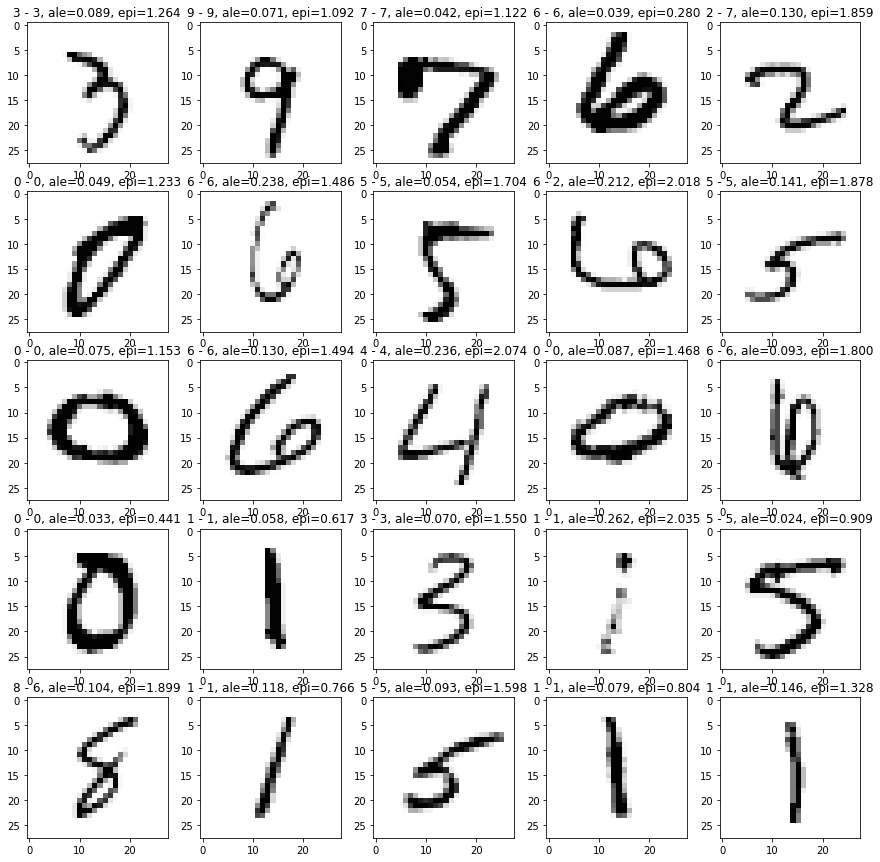

In [64]:
k = 25
#p=prob_std / prob_std.sum()
#vr = variation_ratio(prob)
p = epistemic / epistemic.mean() # 
p = aleatoric / aleatoric.mean()
p = p / p.sum()

fig, axs = plt.subplots(ncols=(k / 5), nrows=5)
axs = axs.ravel()
for i, i_test in enumerate(np.random.choice(len(y_test), k, p=p)):
    img = X_test[i_test].reshape(28, 28) * 255
    axs[i].imshow(img, cmap=plt.cm.get_cmap('Greys'))
    axs[i].set_title('%d - %d, ale=%.3f, epi=%.3f' % (y_test[i_test].argmax(), 
                                               prob_mean[i_test].argmax(),
                                               aleatoric[i_test],
                                               epistemic[i_test]))
fig.set_size_inches(15, 15)

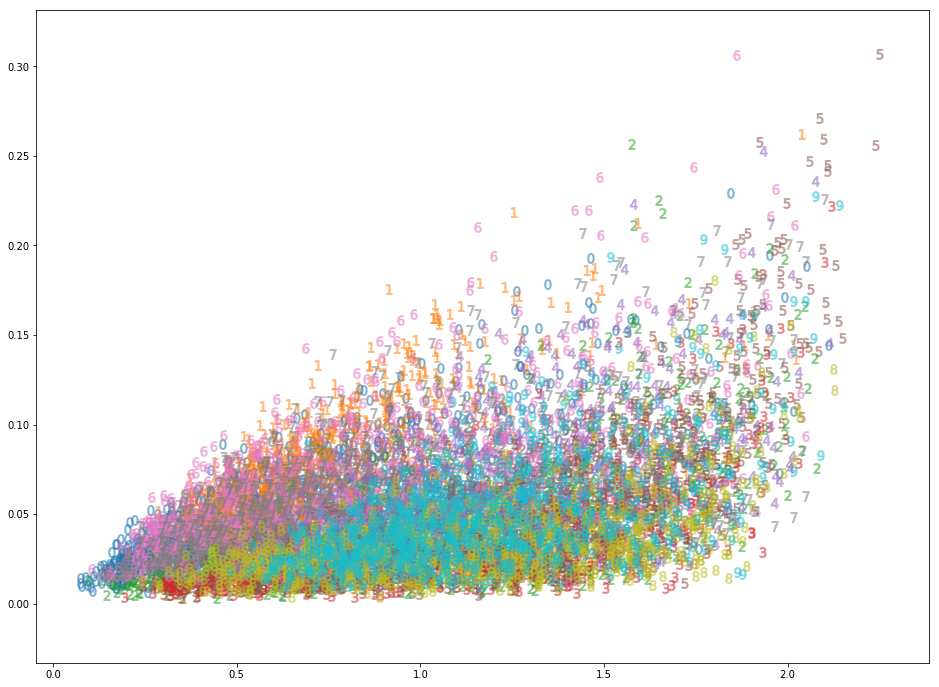

In [55]:
fig = plt.figure(111)
for yy in xrange(0, 10):
    index = y_test[:, yy].astype(bool)
    plt.scatter(epistemic[index], aleatoric[index], marker='$%d$' % yy, alpha=0.4, s=100)
fig.set_size_inches(16, 12)

plt.show()

In [54]:
%matplotlib inline

In [105]:
plt.hist(epistemic/epistemic.mean())
plt.hist(aleatoric/aleatoric.mean())

(array([  1.52300000e+03,   3.30700000e+03,   2.65500000e+03,
          1.46100000e+03,   6.72000000e+02,   2.52000000e+02,
          9.10000000e+01,   2.80000000e+01,   1.00000000e+01,
          1.00000000e+00]),
 array([ 0.08022246,  0.48381906,  0.88741567,  1.29101228,  1.69460889,
         2.09820549,  2.5018021 ,  2.90539871,  3.30899531,  3.71259192,
         4.11618853]),
 <a list of 10 Patch objects>)

In [142]:
i = 10
x0 = X_train[i]
y0 = y_train[i]
y_opt = 5

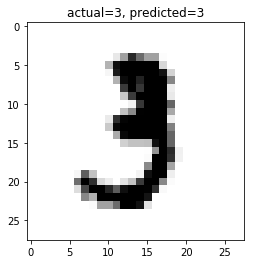

In [143]:
plt.imshow(x0.reshape(28, 28), cmap='Greys')
plt.title('actual=%d, predicted=%d' % (y0.argmax(), model.predict(x0.reshape(1, -1))[0].argmax()))

In [144]:
def min_f(delta_x):
    return 1 - model.predict((x0+delta_x).reshape(1, -1))[0, y_opt]

In [145]:
delta_t = K.placeholder((None, len(x0)), dtype='float32')

In [146]:
type(delta_t)

theano.tensor.var.TensorVariable

In [147]:
cost = 1 - model.outputs[0][0, y_opt]

In [148]:
f = K.function([delta_t], [cost], 
               givens={
                   K.learning_phase(): np.uint8(0),
                   model.input: delta_t + x0.astype('float32')
               })

In [149]:
grad = K.gradients(cost, model.input)

In [150]:
f_prime = K.function([delta_t], [grad], 
               givens={
                   K.learning_phase(): np.uint8(0),
                   model.input: delta_t + x0.astype('float32')
               })

In [151]:
import scipy.optimize


In [152]:
def cb(x):
    print(min_f(x))

In [153]:
def min_f(delta):
    return f([delta.reshape(1, -1)])[0]

def min_f_prime(delta):
    return f_prime([delta.reshape(1, -1)])[0][0]

In [154]:
res = scipy.optimize.fmin_tnc(min_f,
                              x0=np.random.normal(0, 1, size=len(x0)),
                              fprime=min_f_prime,
                              bounds=[(-0.45, 0.45)] * len(x0),
                              callback=cb)

0.997154891491
0.996424496174
0.99621874094
0.995708048344
0.99457013607
0.994449079037
0.994049370289
0.993438959122
0.99205160141
0.98751693964
0.986022114754
0.985693216324
0.984376430511
0.982167720795
0.979218780994
0.971320569515
0.970723330975
0.965418338776
0.948014914989
0.88466501236
0.841940164566
0.824197649956
0.712248265743
0.689657568932
0.590094923973
0.526095271111
0.483880221844
0.467673838139
0.466784656048
0.466776788235
0.466717123985
0.425501704216
0.425320863724
0.400018393993
0.396305799484
0.392392575741
0.392183482647
0.39217621088
0.273740291595
0.273739993572
0.270152926445
0.269679069519
0.24405092001
0.228203475475
0.222614765167
0.190122067928
0.178263604641
0.177717030048
0.174577593803
0.160222411156
0.15920740366
0.158995389938
0.149954020977
0.122697293758
0.11710524559
0.107223987579
0.107223153114
0.107205748558
0.0998542904854
0.0995843410492
0.0958536863327
0.0891734957695
0.0884926319122
0.078629553318
0.0767023563385
0.0731208324432
0.0709130764

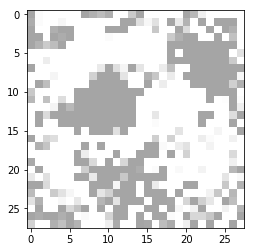

In [155]:
plt.imshow(res[0].reshape(28, 28), cmap='Greys', vmin=0, vmax=1)

In [161]:
# model - the trained classifier(C classes) 
#where the last layer applies softmax
# X_data - a list of input data(size N)
# T - the number of monte carlo simulations to run
def montecarlo_prediction_epistemic_aleatoric(model, X_data, T):
# shape: (T, N, C)
    predictions = np.array([model.predict_stochastic(X_data, batch_size=750, verbose=False) for _ in range(T)])
    #print(predictions.shape)
    
    # shape: (N, C)
    prediction_probabilities = np.mean(predictions, axis=0)
    
    #print(prediction_probabilities.shape)
    # shape: (N)
    prediction_variances = np.apply_along_axis(predictive_entropy, axis=1, arr=prediction_probabilities)
    
    var = model.predict(X_data, batch_size=500)[1][:, -1]
    
    
    return (prediction_probabilities, prediction_variances, var)

# prob - prediction probability for each class(C). Shape: (N, C)
# returns - Shape: (N)
def predictive_entropy(prob):
    #print(prob.shape)
    return -1 * np.sum(np.log(prob) * prob)

In [162]:
model.predict((x0+res[0]).reshape(1, -1))[0].argmax()

5

In [164]:
prob, epi, ale = montecarlo_prediction_epistemic_aleatoric(model, (x0+res[0]).reshape(1, -1), 100)

In [166]:
prob.argmax(), epi, ale

(5, array([ 0.05625128]), array([ 0.00171282], dtype=float32))

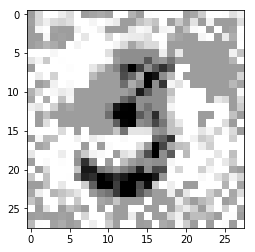

In [165]:
plt.imshow((res[0] + x0).reshape(28, 28), cmap='Greys')

In [182]:
_predict_stochastic = K.function([model.inputs[0]], [model.outputs[1]],
                                                      givens={K.learning_phase(): np.uint8(1)})

In [187]:


o1 = np.sqrt(np.array([model._predict_loop(_predict_stochastic,
                                   [np.atleast_2d(x0)], batch_size=batch_size, verbose=False)[:, -1]
               for _ in xrange(200)]))

In [188]:
o2 = np.sqrt(np.array([model._predict_loop(_predict_stochastic,
                                   [np.atleast_2d(x0+res[0])], batch_size=batch_size, verbose=False)[:, -1]
               for _ in xrange(200)]))

In [189]:
o1.mean(), o1.std()

(0.076078303, 0.031538196)

In [190]:
o2.mean(), o2.std()

(0.048988909, 0.03574637)

In [168]:
probs0 = np.array([model.predict_stochastic(np.atleast_2d(x0))[0] for _ in xrange(100)])

probs0.argmax(1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3])

In [171]:
probs0 = np.array([model.predict_stochastic(np.atleast_2d(x0+res[0]))[0] for _ in xrange(100)])

probs0.argmax(1)

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5])